## Quick overview dashboards

To give a quick overview of the data and fulfill your basic curiosities about it. Other dashboards give deeper analysis.

In [1]:
import glob
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import re

import customChartDefaultStyling
import oddsportal_compileDF

pd.set_option('display.max_columns', None)

colors = {'home': {'r': 0,'g': 100, 'b': 0}, 'draw': {'r': 249,'g': 180, 'b': 45}, 'away': {'r': 255,'g': 0, 'b': 0},}
def getColor(wintype, alpha):    
    return f'rgba({colors[wintype]["r"]}, {colors[wintype]["g"]}, {colors[wintype]["b"]}, {alpha})'

dBOOKIES = dict((row['bookie_code'], row['bookie_name']) for index, row in pd.read_csv('CSVs/dfBOOKIES.csv').iterrows())
dBOOKIES[0] = 'unknown'

In [59]:
def makeSubplots(country, competitions_list):
    
    df = oddsportal_compileDF.getDFCONCAT(country, competitions_list)
    df['shortest_close'] = np.where((df['home_win'] < df['draw']) & (df['home_win'] < df['away_win']), 'home', np.where((df['draw'] < df['home_win']) & (df['draw'] < df['away_win']), 'draw', np.where((df['away_win'] < df['home_win']) & (df['away_win'] < df['draw']), 'away', None)))
    df['shortest_opening'] = np.where((df['home_win_opening'] < df['draw_opening']) & (df['home_win_opening'] < df['away_win_opening']), 'home', np.where((df['draw_opening'] < df['home_win_opening']) & (df['draw_opening'] < df['away_win_opening']), 'draw', np.where((df['away_win_opening'] < df['home_win_opening']) & (df['away_win_opening'] < df['draw_opening']), 'away', None)))
    df['haOpenEqual'] = np.where((df['home_win'] == df['away_win']), 1,0)

    ####
    
    fig = make_subplots(
        rows=2, cols=5,
        specs=[[{}, {}, {}, {}, {}],
               [{"colspan": 5}, None, None, None, None]]
        )
    
    default_color = 'rgb(23,45,187)'
    
    def subBar(col_name, df_limit, plot_row, plot_col):
        
        dfSP = df.copy()
        
        if col_name == 'shortest':
            
            dfSP1 = dfSP['shortest_close'].value_counts().to_frame().rename(columns={0:'amount'})
            dfSP1['close_pc'] = dfSP1['shortest_close'] / dfSP1['shortest_close'].sum() * 100
            
            dfSP2 = dfSP['shortest_opening'].value_counts().to_frame().rename(columns={0:'amount'})
            dfSP2['open_pc'] = dfSP2['shortest_opening'] / dfSP2['shortest_opening'].sum() * 100
            
            dfSP = dfSP1.merge(dfSP2, left_on=dfSP1.index, right_on=dfSP2.index)
            #dfSP['amount'] = dfSP['shortest_close'] - dfSP['shortest_opening']
            dfSP['amount'] = round(dfSP['close_pc'] - dfSP['open_pc'], 2)
            dfSP.index = dfSP['key_0']
                        
        else:
            
            if col_name in ['winning_odds']:
                dfSP[col_name] = dfSP[col_name].apply(lambda x: round(x,1))
            
            dfSP = dfSP[[col_name]].value_counts().to_frame().rename(columns={0:'amount'})
            dfSP.index = [x[0] for x in dfSP.index] 
        
        ## 
        
        dfSP = dfSP.iloc[0:df_limit]
                
        if col_name in ['winner', 'shortest_close', 'shortest']:
            colors = [getColor(x, 1) for x in dfSP.index]
        else:
            colors = [default_color for x in dfSP.index]
                        
        x, y = dfSP.index, dfSP['amount']
        fig.add_trace(go.Bar(x=x,y=y, marker=dict(color=colors), hovertemplate='%{x}: %{y}<extra></extra>'), row=plot_row, col=plot_col)
        
    def subScatter(col_name_X, col_name_Y, plot_row, plot_col):
        
        dfSP = df[[col_name_X, col_name_Y]].value_counts().to_frame().reset_index().rename(columns={0:'amount'})
        dfSP['hover_text'] = dfSP[col_name_X].apply(lambda x: str(int(x))) + ', ' + dfSP[col_name_Y].apply(lambda x: str(int(x))) + ': ' + dfSP['amount'].apply(lambda x: str(x))
        fig.add_trace(go.Scatter(x=dfSP[col_name_X], y=dfSP[col_name_Y], mode='markers', marker=dict(color=default_color, size=[x**0.25 for x in dfSP['amount']]), hovertext=dfSP['hover_text'], hoverinfo='text'), row=plot_row, col=plot_col)
                
    subBar('winner', None, 1, 1)
    subBar('shortest_close', None, 1, 2)
    subBar('shortest', None, 1, 3)
    subScatter('H', 'A', 1, 4)
    subBar('bookie_name', 15, 1, 5)
    
    winning_odds_cutoff = 20
    subBar('winning_odds', winning_odds_cutoff, 2, 1)
    
    ### 
    
    headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend = ', '.join([x.title() for x in df['country'].unique()]), ', '.join([x for x in df['competition'].unique()]), None, None, 500, 70, False
    customChartDefaultStyling.styling(fig, headline, subhead, xaxes_title, yaxes_title, figHeight, marginTop, showLegend)

    # edit axis labels
    fig['layout']['xaxis']['title']= 'result type'
    fig['layout']['xaxis2']['title']= 'shortest odds at closing' 
    fig['layout']['xaxis3']['title']= 'shortest odds ppt change'
    fig['layout']['xaxis4']['title']= 'home (x) * away (y) goals'
    fig['layout']['xaxis5']['title']= 'bookmakers'    
    fig['layout']['xaxis6']['title']= f'winning odds (rounded, top {winning_odds_cutoff})'
    
    fig.show()

championship          (329376, 37)	(329376, 37)


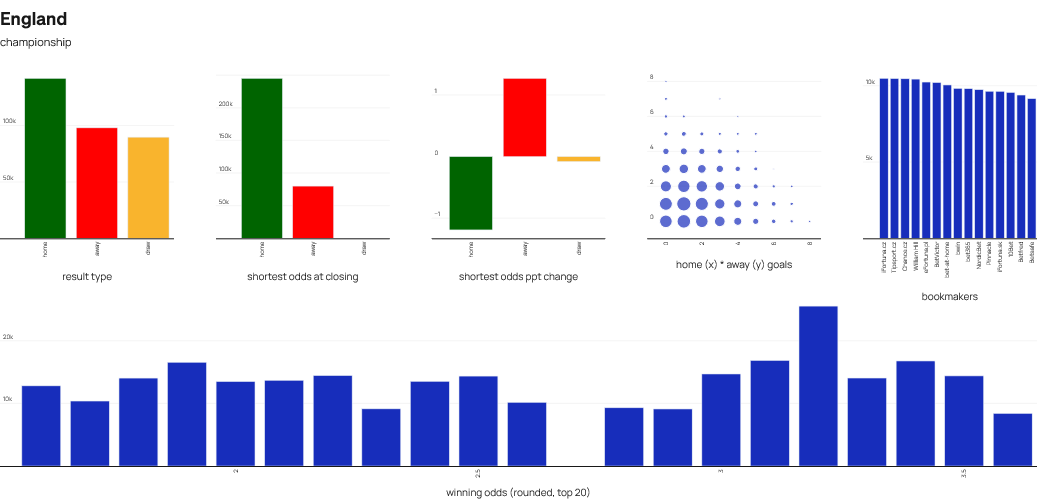

In [61]:
makeSubplots('england', ['championship'])

isthmian-league-prem  (99468, 37)	(99468, 37)
npl-premier-division  (100308, 37)	(199776, 37)
isthmian-league-prem  (99468, 37)	(299244, 37)
southern-league-sout  (32376, 37)	(331620, 37)


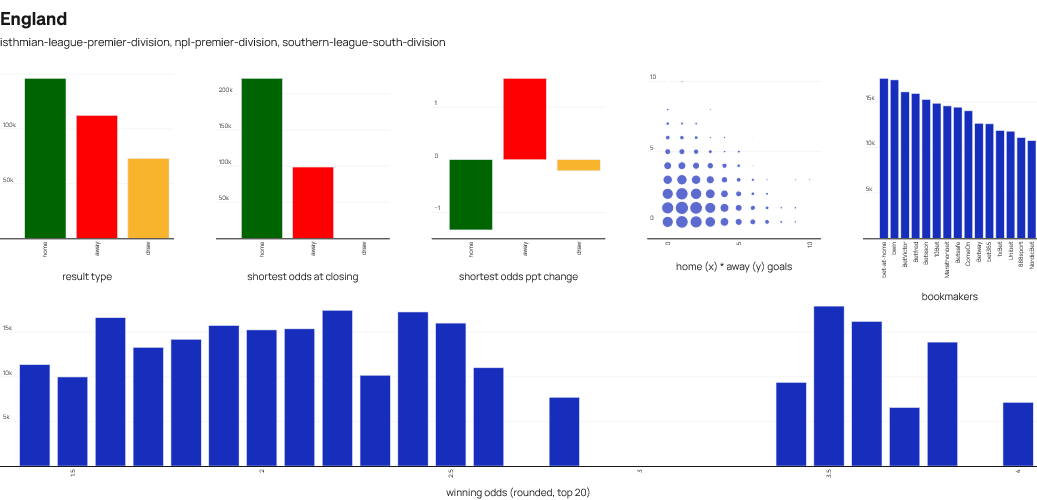

In [62]:
makeSubplots('england', ['isthmian-league-premier-division', 'npl-premier-division', 'isthmian-league-premier-division', 'southern-league-south-division'])

a-league              (69554, 37)	(69554, 37)
australia-cup         (7771, 37)	(77325, 37)
brisbane-premier-lea  (23123, 37)	(100448, 37)
npl-act               (14352, 37)	(114800, 37)
npl-northern-nsw      (22121, 37)	(136921, 37)
npl-nsw               (39416, 37)	(176337, 37)
npl-queensland        (43658, 37)	(219995, 37)
npl-south-australian  (42471, 37)	(262466, 37)
npl-tasmania          (18006, 37)	(280472, 37)
npl-victoria          (53414, 37)	(333886, 37)
npl-western-australi  (43417, 37)	(377303, 37)


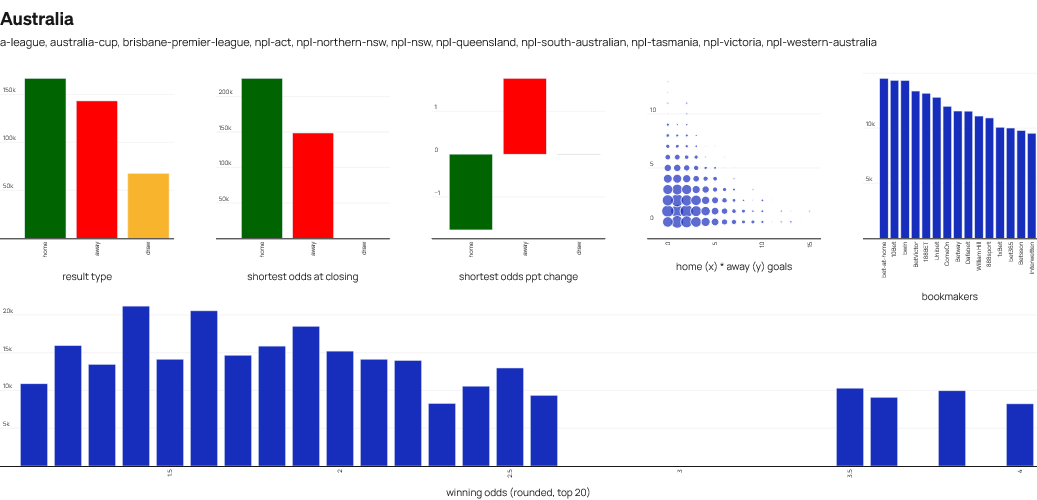

In [63]:
makeSubplots('australia', None)